# Regression with Controls

First we aggregate the data into a single dataframe across the two cities

In [123]:
import pandas as pd

barcelona_control = pd.read_csv('/content/Barcelona_Control_19_23.csv')
barcelona_treatment = pd.read_csv('/content/Barcelona_Treatment_12_16.csv')
alicante_control = pd.read_csv('/content/Alicante_before.csv')
alicante_treatment = pd.read_csv('/content/Alicante_festival.csv')

alicante_control['Treatment_City'] = 0
alicante_control['Treatment_Period'] = 0

alicante_treatment['Treatment_City'] = 0
alicante_treatment['Treatment_Period'] = 1

data = pd.concat([barcelona_control, barcelona_treatment, alicante_control, alicante_treatment], axis = 0)

data

,Unnamed: 0,Hotel Name,Rating,Price,Hotel URL,Descriptions,Treatment_Period,Treatment_City
0,0,Casa Abamita,"8,5",€ 1.104,https://www.booking.com/hotel/es/mayerling-aba...,Los Apartamentos Mayerling Abamita se encuentr...,0,1
1,1,ME Barcelona,"9,2",€ 2.564,https://www.booking.com/hotel/es/me-barcelona-...,ME Barcelona es un alojamiento con una ubicaci...,0,1
2,2,SM Hotel Teatre Auditori,"8,5",€ 960,https://www.booking.com/hotel/es/teatre-audito...,El SM Hotel Teatre Auditori se encuentra frent...,0,1
3,3,Catalonia Sagrada Familia,"8,2",€ 1.003,https://www.booking.com/hotel/es/cataloniaarag...,El Catalonia Sagrada Familia se halla a 15 min...,0,1
4,4,Hostal Levante Barcelona,"7,9",€ 828,https://www.booking.com/hotel/es/hostal-levant...,El Hostal Levante Barcelona está situado a sol...,0,1
...,...,...,...,...,...,...,...,...
871,871,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,"6,2",€ 1.440,https://www.booking.com/hotel/es/otlichnaia-ui...,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,0,0
872,872,Large rural house with pool and barbecue,"8,0",€ 2.742,https://www.booking.com/hotel/es/large-rural-h...,Large rural house with pool and barbecue tiene...,0,0
873,873,The Market Hostel,"8,6",€ 193,https://www.booking.com/hotel/es/the-market-ho...,The Market Hostel está a menos de 1 km de Play...,0,0
874,874,Victoria Hospedaje,"9,0",€ 280,https://www.booking.com/hotel/es/victoria-alic...,"Victoria Hospedaje se encuentra en Alicante, c...",0,0


There are some descriptions in the dataset that are in english, and we want them all to be spanish, so we use this function to translate the english ones to spanish

In [124]:
#!pip install langdetect
#!pip install googletrans==4.0.0-rc1

# Detect which language the description is in
from langdetect import detect
data['language'] = data['Descriptions'].apply(lambda x: detect(x) if type(x) == str else None)
data

# Count total descriptions in Spanish and in English
english_count = data[data['language'] == 'en'].shape[0]
spanish_count = data[data['language'] == 'es'].shape[0]
print(f'Number of descriptions in English: {english_count}')
print(f'Number of descriptions in Spanish: {spanish_count}')

# Display the rows where the language is English
english_rows = data[data['language'] == 'en']
print(english_rows)

from googletrans import Translator

# Translate to Spanish
def translate_to_spanish(text):
    translator = Translator()
    translation = translator.translate(text, src='en', dest='es')
    return translation.text

english_descriptions = data[data['language'] == 'en']['Descriptions']

# Translate English descriptions to Spanish
data.loc[data['language'] == 'en', 'Descriptions'] = english_descriptions.apply(translate_to_spanish)

print(data)

Number of descriptions in English: 20
Number of descriptions in Spanish: 3794
      Unnamed: 0                         Hotel Name Rating    Price  \
65            65   Torre Melina, a Gran Meliá Hotel    NaN  € 2.390   
191          191              TOC Hotel Las Ramblas    8,3  € 1.544   
299          299                      Barceló Sants    8,6  € 1.164   
385          385       Àmfores Boutique Guest House    8,1    € 983   
415          415             Sonder La Casa del Sol    7,9  € 1.071   
424          424   DO Plaça Reial powered by Sonder    8,4  € 1.492   
462          462               Ant Hostel Barcelona    7,0  € 1.033   
495          495          Twentytu Hostel Barcelona    7,7  € 2.353   
995          995                      Anba Boutique    8,9  € 1.398   
1020        1020                      Anba Boutique    8,9  € 1.398   
160          160                      Barceló Sants    8,6    € 885   
185          185   Torre Melina, a Gran Meliá Hotel    NaN  € 1.995   

We have chosen to use amenities and location-related words to add as controls for the model. We use an TFIDF matrix to find those words that are both unique and related to amenities and location. We remove stopwords and perform n-gramming before printing the list.

In [125]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

data['Description'] = data['Descriptions'].fillna('')
data['Descriptions'] = data['Descriptions'].astype(str)

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=spanish_stopwords, ngram_range=(1,1))

# Fit and transform the processed descriptions to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Descriptions'])

# Get the feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Sum the TF-IDF scores for each term across all documents
sum_tfidf = tfidf_matrix.sum(axis=0)

# Sort indices in descending order of TF-IDF scores
sorted_indices = np.argsort(sum_tfidf).flatten()[::-1]

# Get the top 500 words and their scores
top_500_words = feature_names[sorted_indices[:500]]
top_500_scores = np.array(sum_tfidf)[0, sorted_indices[:500]]

# Print the top 100 words with their TF-IDF scores
for word, score in zip(top_500_words, top_500_scores):
    print(f"{word}")

# Ensure that the data extracted is 1-dimensional
top_500_words = feature_names[sorted_indices[:500]].flatten()
top_500_scores = np.array(sum_tfidf)[0, sorted_indices[:500]].flatten()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['bitérmica' 'tallada' 'acogedora' ... 'alojamiento' 'km' 'alicante']


In [126]:
top_500_words

array(['bitérmica', 'tallada', 'acogedora', ..., 'alojamiento', 'km',
       'alicante'], dtype=object)

The plot below implies that none of the words is much more unique than the other top words. Instead, the plot is quite uniform. This is good as it means we get a nice subset of words related to amenity and location that are all informative to a similar extent.

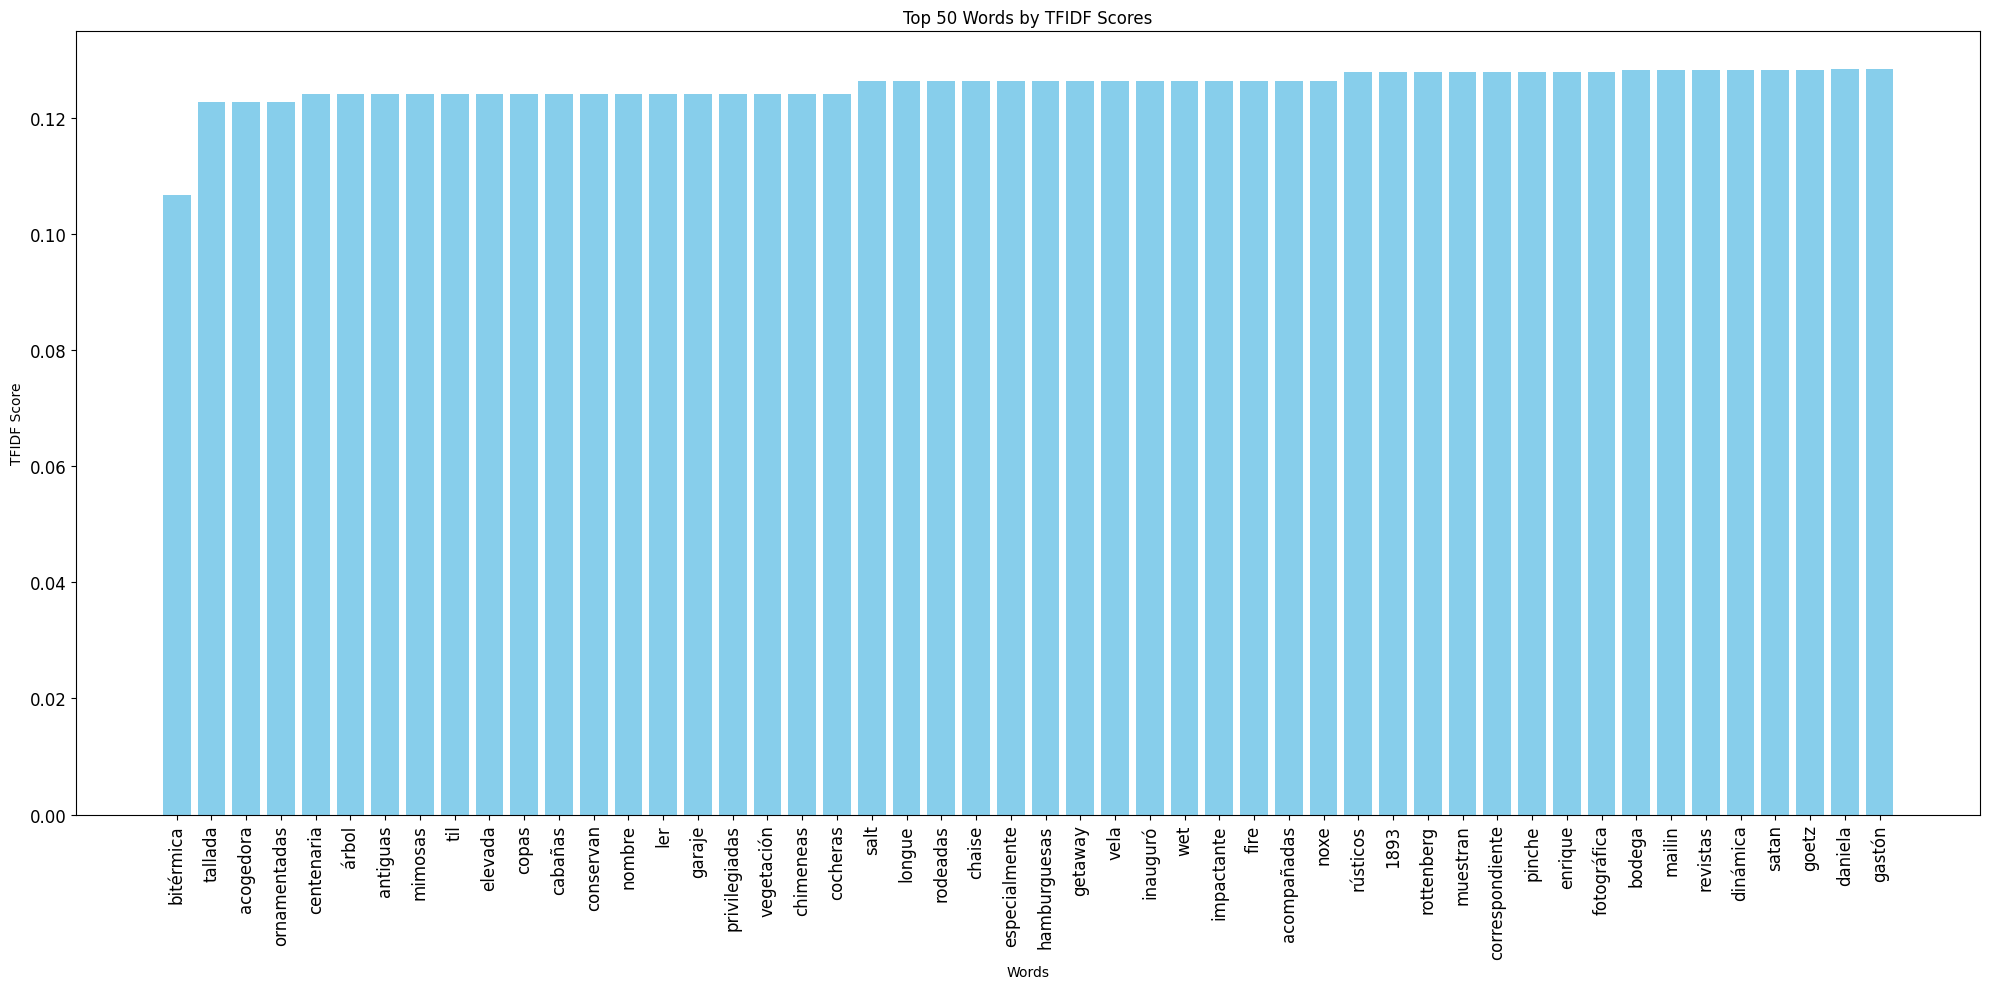

In [127]:
#Now we plot the top words in the TFIDF matrix by their score

import matplotlib.pyplot as plt
import pandas as pd

top_df = pd.DataFrame({'word': top_500_words, 'tfidf score': top_500_scores})

top_500_df = top_df[:500]

top_50_df = top_500_df[:50]

# Proceed to plot
plt.figure(figsize=(20, 10))  # Adjust figure size for better visibility
plt.bar(top_50_df['word'], top_50_df['tfidf score'], color='skyblue')

plt.ylabel('TFIDF Score')
plt.xlabel('Words')
plt.title('Top 50 Words by TFIDF Scores')

# Rotate the x labels to fit them better and set font size to small
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout
plt.show()

Now we pick out the words from the top 500 that relate to amenities and location. We have been quite generous with inclusion criteria as we don't want too much researcher judgement to interfere with the results

In [128]:
# Select words from the top 500 ITFDF scores related to amenities and location:
amenities_itfdf = [
    'wifi', 'garaje', 'vegetación', 'chimeneas', 'piscina', 'spa', 'gimnasio', 'parking',
    'desayuno', 'terraza', 'jacuzzi', 'bar', 'restaurante', 'cafetería', 'recepción',
    'seguridad', 'vistas', 'aire acondicionado', 'calefacción', 'habitaciones', 'limpieza',
    'minibar', 'tv', 'ducha', 'baño', 'ascensor', 'balcón', 'servicio habitaciones',
    'salón', 'jardín', 'cama', 'colchón', 'almohadas', 'sábanas', 'toallas', 'secador',
    'lavandería', 'plancha', 'cocina', 'nevera', 'cafetera', 'té', 'servicio despertador',
    'botella agua', 'botella vino', 'cóctel bienvenida', 'prensa diaria', 'almuerzo',
    'cena', 'gourmet', 'degustación', 'playa', 'golf', 'tenis', 'equitación', 'buceo',
    'vela', 'esquí', 'senderismo', 'bicicleta', 'fitness', 'masajes', 'tratamientos belleza',
    'sauna', 'hammam', 'belleza', 'peluquería', 'boutique', 'tienda regalos', 'joyería',
    'souvenirs', 'guardaequipaje', 'conserje', 'guía turístico', 'excursiones', 'entradas',
    'reservas', 'traslados', 'alquiler coches', 'alquiler bicicletas', 'servicio niñera',
    'cuidado niños', 'animación infantil', 'cunas', 'camas extras', 'sofá cama', 'suites',
    'habitaciones comunicadas', 'habitaciones familiares', 'adaptado movilidad reducida',
    'servicio médico', 'primeros auxilios', 'evacuación emergencia', 'detector humo',
    'cámaras seguridad', 'caja fuerte', 'cerradura seguridad', 'tarjeta acceso', 'wifi gratis',
    'estación carga', 'punto internet', 'ordenadores', 'impresora', 'fax', 'fotocopiadora',
    'salas reuniones', 'salas conferencias', 'centro negocios', 'exposiciones', 'eventos',
    'bodas', 'celebraciones', 'fiestas', 'cócteles', 'banquetes', 'catering', 'barbacoa',
    'terraza solárium', 'piscina cubierta', 'piscina exterior', 'piscina niños', 'piscina infinita',
    'tumbonas', 'sombrillas', 'duchas exterior', 'spa urbano', 'centro wellness', 'yoga',
    'pilates', 'meditación', 'retiros', 'detox', 'nutrición', 'dieta personalizada',
    'entrenador personal', 'clases cocina', 'talleres', 'charlas', 'conferencias', 'exhibiciones',
    'galería arte', 'biblioteca', 'libros', 'juegos mesa', 'sala juegos', 'sala cine', 'teatro'
]

location_itfdf = ['vegetación','vistas', 'inauguró', 'dalt', 'cosmocaixa', 'sagrado', 'cosmopolitas', 'mercados',
                  'playa', 'golf', 'puerto', 'parque', 'plaza', 'pirineos','chiringuitos', 'collserola','panorámicos',
                  'terraza', 'promenade', 'playa']


Now we find the top words across all documents. While these words are less informative about a single document than the TFIDF matrix because they are used widely across the dataset, their absence may also be a useful indicator.

In [129]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'data' is your DataFrame and 'Descriptions' is the column with hotel descriptions

# Step 1: Initialize CountVectorizer
# We don't set max_features=500 here because we first want to create the full document frequency matrix
vectorizer = CountVectorizer(analyzer='word', stop_words=spanish_stopwords, ngram_range=(1,1))

# Step 2: Fit the vectorizer to the 'Descriptions' and transform the text to a document frequency matrix
X = vectorizer.fit_transform(data['Descriptions'])

# Step 3: Sum the occurrence of each word across all documents to find the most used words
word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Step 4: Sort the words by their frequency
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

pd.DataFrame(words_freq)

# Step 5: Extract the top 500 words
top_500_words_docfreq = words_freq[:500]

# Convert the list of tuples into two lists: one for words and another for their corresponding frequencies
words_freq_df = pd.DataFrame(words_freq)

# Now `top_500_words_list` contains the top 500 most used words in the 'Descriptions' column
print(top_500_words_docfreq)


[('km', 8229), ('alojamiento', 6766), ('alicante', 6261), ('aeropuerto', 5693), ('apartamento', 4712), ('ofrece', 4591), ('barcelona', 4209), ('pie', 3737), ('aire', 3435), ('wifi', 3154), ('acondicionado', 3019), ('estación', 2869), ('cocina', 2863), ('tv', 2605), ('gratis', 2484), ('playa', 2481), ('minutos', 2353), ('baño', 2271), ('encuentra', 2267), ('hotel', 2078), ('cerca', 2067), ('habitaciones', 2047), ('nevera', 1862), ('metros', 1811), ('interés', 1808), ('pantalla', 1788), ('cama', 1784), ('plana', 1775), ('min', 1753), ('cercano', 1726), ('vistas', 1705), ('terraza', 1698), ('equipada', 1697), ('zona', 1695), ('ropa', 1687), ('toallas', 1644), ('tren', 1634), ('puntos', 1622), ('centro', 1576), ('privado', 1551), ('ducha', 1515), ('metro', 1502), ('elche', 1490), ('miguel', 1489), ('hernández', 1488), ('cuenta', 1434), ('plaza', 1425), ('museo', 1374), ('dormitorios', 1341), ('dispone', 1324), ('san', 1309), ('ciudad', 1297), ('totalmente', 1290), ('postiguet', 1278), ('gr

The plot below shows the words are distributed according to a Zipfian distribution as we would expect with natural language. Some words are really uninformative, like 'km' which is mentioned in nearly every document. However, most of the words are only mentioned in 1000-2000 documents, so are actually quite informative for subsetting the hotels.

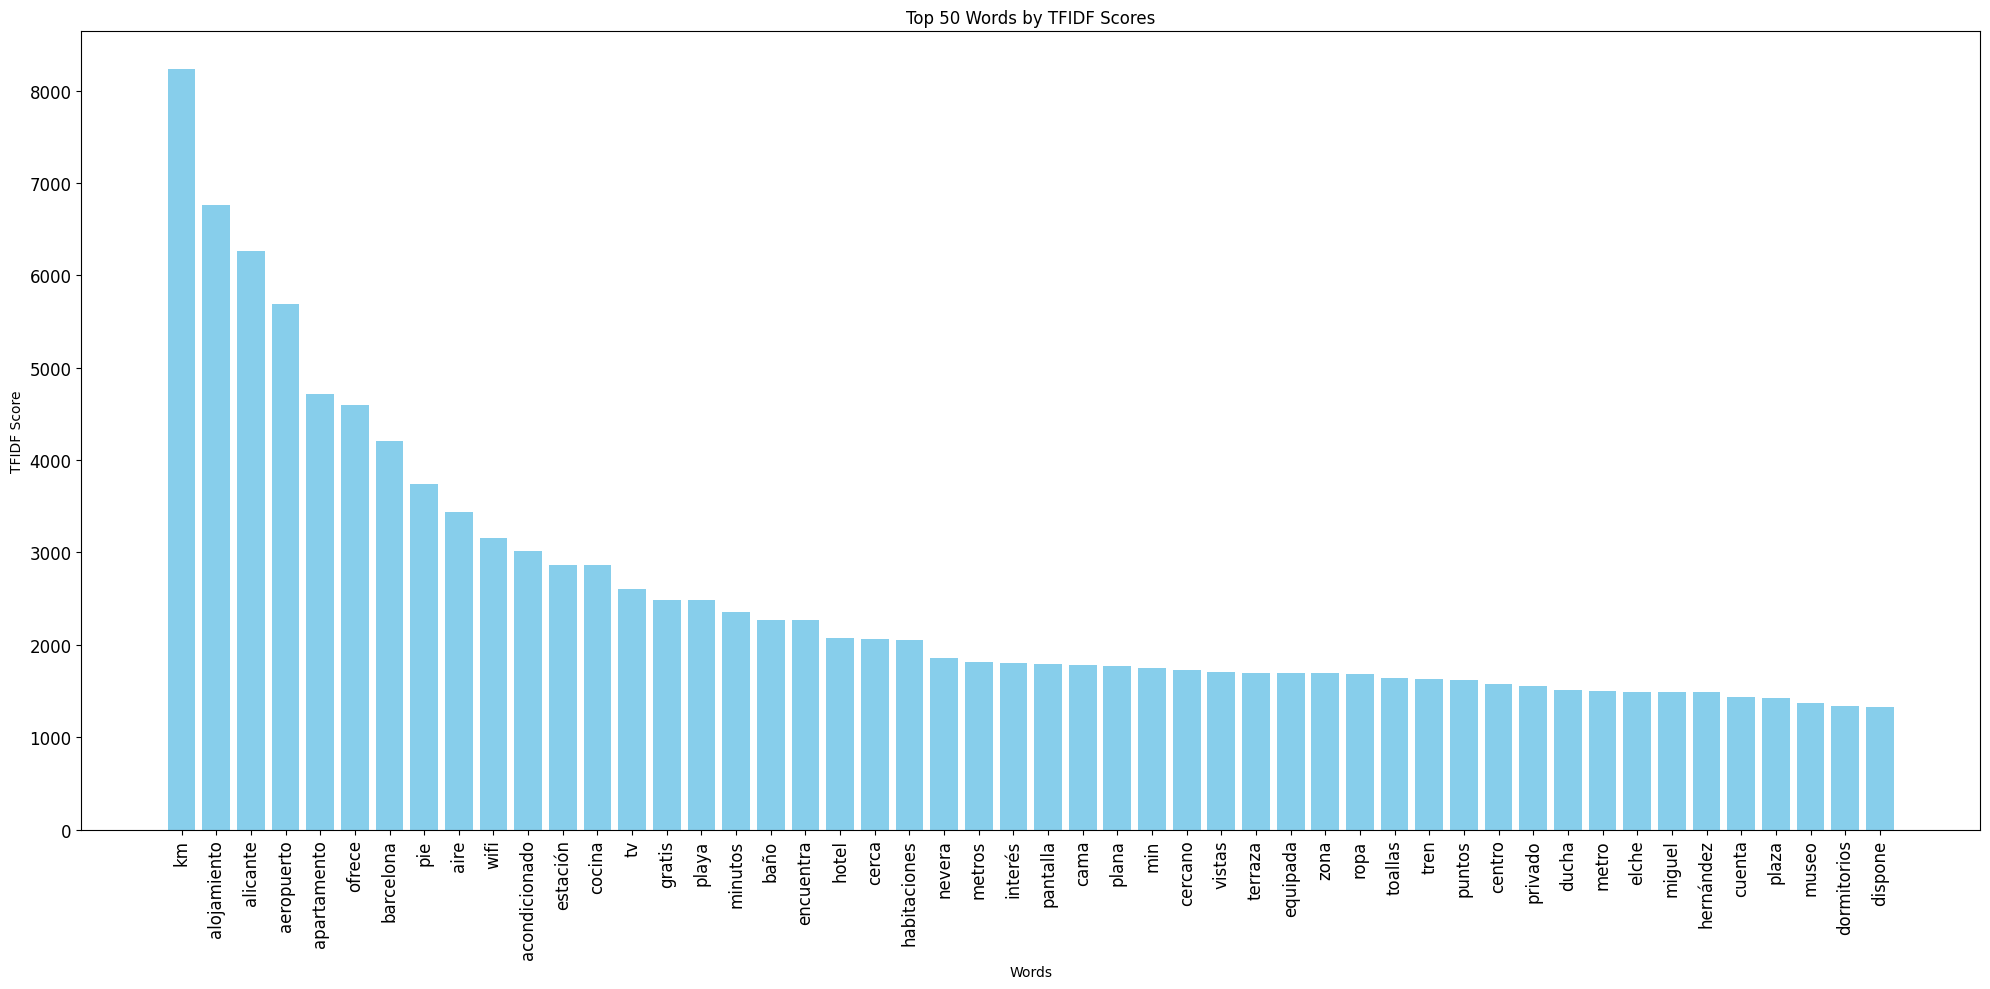

In [130]:
#Now we plot the top words by their score

import matplotlib.pyplot as plt
import pandas as pd

top_50_freq_df = words_freq_df[:50]

# Proceed to plot
plt.figure(figsize=(20, 10))  # Adjust figure size for better visibility
plt.bar(top_50_freq_df[0], top_50_freq_df[1], color='skyblue')

plt.ylabel('TFIDF Score')
plt.xlabel('Words')
plt.title('Top 50 Words by TFIDF Scores')

# Rotate the x labels to fit them better and set font size to small
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout
plt.show()

In [131]:
amenities_freq = [
    "wifi", "aire acondicionado", "cocina", "tv", "gratis", "playa",
    "baño", "habitaciones", "nevera", "pantalla plana", "vistas", "terraza",
    "ropa", "toallas", "ducha", "privado", "cama", "piscina", "golf", "servicio",
    "desayuno", "parking", "hervidor", "lavavajillas", "microondas", "recepción",
    "bar", "jardín", "restaurante", "satélite", "secador pelo", "cafetera",
    "minibar", "gimnasio", "spa", "sauna", "cable", "bicicletas", "hidromasaje",
    "aparcamiento", "calefacción", "traslado", "alquiler", "solarium", "acceso",
    "caja fuerte", "suites", "canales", "lavadora"
]

location_freq = [
    "alicante", "aeropuerto", "barcelona", "playa", "estación", "cerca", "centro", "elche", "plaza", "museo",
    "ciudad", "postiguet", "catedral", "españa", "prat", "san", "gracia", "explanada", "paseo", "arte",
    "mercado", "parque", "batlló", "cataluña", "sagrada", "familia", "ramblas", "mar", "restaurantes", "vía",
    "jardín", "catalunya", "montjuïc", "boquería", "barceloneta", "rambla", "puerto", "gótico", "eixample",
    "gaudí", "sants", "gràcia", "diagonal", "santa", "palacio", "turística", "gran", "ubicación", "fuente",
    "montaña", "ciutadella", "barrio", "plaça", "nou", "born", "raval", "parquet", "urquinaona", "olimpic",
    "pau", "turístico", "sebastià"
]

amenities = amenities_itfdf + amenities_freq
location = location_itfdf + location_freq

Now we count the number of occurances of the words in 'amenities' and the words in 'location' in each hotel's description and add them to two new columns.

In [132]:
data['amenities'] = 0
data['location'] = 0

def amenities_count(description):
    # Lowercase the description to improve matching
    description_lower = description.lower()
    # Sum the occurrences of each amenity word in the description
    return sum(description_lower.count(amenity.lower()) for amenity in amenities)

# Apply the corrected function to each row in the 'Descriptions' column
data['amenities'] = data['Descriptions'].apply(amenities_count)

def location_count(description):
    # Lowercase the description to improve matching
    description_lower = description.lower()
    # Sum the occurrences of each amenity word in the description
    return sum(description_lower.count(location.lower()) for location in location)

# Apply the corrected function to each row in the 'Descriptions' column
data['location'] = data['Descriptions'].apply(location_count)


In [133]:
data

,Unnamed: 0,Hotel Name,Rating,Price,Hotel URL,Descriptions,Treatment_Period,Treatment_City,language,Description,amenities,location
0,0,Casa Abamita,"8,5",€ 1.104,https://www.booking.com/hotel/es/mayerling-aba...,Los Apartamentos Mayerling Abamita se encuentr...,0,1,es,Los Apartamentos Mayerling Abamita se encuentr...,31,13
1,1,ME Barcelona,"9,2",€ 2.564,https://www.booking.com/hotel/es/me-barcelona-...,ME Barcelona es un alojamiento con una ubicaci...,0,1,es,ME Barcelona es un alojamiento con una ubicaci...,53,23
2,2,SM Hotel Teatre Auditori,"8,5",€ 960,https://www.booking.com/hotel/es/teatre-audito...,El SM Hotel Teatre Auditori se encuentra frent...,0,1,es,El SM Hotel Teatre Auditori se encuentra frent...,24,13
3,3,Catalonia Sagrada Familia,"8,2",€ 1.003,https://www.booking.com/hotel/es/cataloniaarag...,El Catalonia Sagrada Familia se halla a 15 min...,0,1,es,El Catalonia Sagrada Familia se halla a 15 min...,35,19
4,4,Hostal Levante Barcelona,"7,9",€ 828,https://www.booking.com/hotel/es/hostal-levant...,El Hostal Levante Barcelona está situado a sol...,0,1,es,El Hostal Levante Barcelona está situado a sol...,26,9
...,...,...,...,...,...,...,...,...,...,...,...,...
871,871,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,"6,2",€ 1.440,https://www.booking.com/hotel/es/otlichnaia-ui...,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,0,0,es,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,25,20
872,872,Large rural house with pool and barbecue,"8,0",€ 2.742,https://www.booking.com/hotel/es/large-rural-h...,Large rural house with pool and barbecue tiene...,0,0,es,Large rural house with pool and barbecue tiene...,27,18
873,873,The Market Hostel,"8,6",€ 193,https://www.booking.com/hotel/es/the-market-ho...,The Market Hostel está a menos de 1 km de Play...,0,0,es,The Market Hostel está a menos de 1 km de Play...,20,23
874,874,Victoria Hospedaje,"9,0",€ 280,https://www.booking.com/hotel/es/victoria-alic...,"Victoria Hospedaje se encuentra en Alicante, c...",0,0,es,"Victoria Hospedaje se encuentra en Alicante, c...",8,23


Now we have to adjust the ratings and price columns. The ratings have commas for decimal points, and the prices have euro signs and points separating thousands from hundreds digits. We also impute missing ratings using KNN.  

In [134]:
#First we need to convert the comma to a dot:

data['Rating'] = data['Rating'].str.replace(',', '.').astype(float)

#And convert price to a float:

data['Price'] = data['Price'].str.replace('€', '').str.replace('.', '').astype(float)


#Now we impute NAs:

from sklearn.impute import KNNImputer

data_for_imputation = data[['Rating']]

imputer = KNNImputer(n_neighbors=10)

data_imputed = imputer.fit_transform(data_for_imputation)

data['Rating'] = data_imputed[:, 0]

<ipython-input-134-eb6fad7034b0>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('€', '').str.replace('.', '').astype(float)


In [135]:
data

,Unnamed: 0,Hotel Name,Rating,Price,Hotel URL,Descriptions,Treatment_Period,Treatment_City,language,Description,amenities,location
0,0,Casa Abamita,8.5,1104.0,https://www.booking.com/hotel/es/mayerling-aba...,Los Apartamentos Mayerling Abamita se encuentr...,0,1,es,Los Apartamentos Mayerling Abamita se encuentr...,31,13
1,1,ME Barcelona,9.2,2564.0,https://www.booking.com/hotel/es/me-barcelona-...,ME Barcelona es un alojamiento con una ubicaci...,0,1,es,ME Barcelona es un alojamiento con una ubicaci...,53,23
2,2,SM Hotel Teatre Auditori,8.5,960.0,https://www.booking.com/hotel/es/teatre-audito...,El SM Hotel Teatre Auditori se encuentra frent...,0,1,es,El SM Hotel Teatre Auditori se encuentra frent...,24,13
3,3,Catalonia Sagrada Familia,8.2,1003.0,https://www.booking.com/hotel/es/cataloniaarag...,El Catalonia Sagrada Familia se halla a 15 min...,0,1,es,El Catalonia Sagrada Familia se halla a 15 min...,35,19
4,4,Hostal Levante Barcelona,7.9,828.0,https://www.booking.com/hotel/es/hostal-levant...,El Hostal Levante Barcelona está situado a sol...,0,1,es,El Hostal Levante Barcelona está situado a sol...,26,9
...,...,...,...,...,...,...,...,...,...,...,...,...
871,871,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,6.2,1440.0,https://www.booking.com/hotel/es/otlichnaia-ui...,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,0,0,es,COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...,25,20
872,872,Large rural house with pool and barbecue,8.0,2742.0,https://www.booking.com/hotel/es/large-rural-h...,Large rural house with pool and barbecue tiene...,0,0,es,Large rural house with pool and barbecue tiene...,27,18
873,873,The Market Hostel,8.6,193.0,https://www.booking.com/hotel/es/the-market-ho...,The Market Hostel está a menos de 1 km de Play...,0,0,es,The Market Hostel está a menos de 1 km de Play...,20,23
874,874,Victoria Hospedaje,9.0,280.0,https://www.booking.com/hotel/es/victoria-alic...,"Victoria Hospedaje se encuentra en Alicante, c...",0,0,es,"Victoria Hospedaje se encuentra en Alicante, c...",8,23


Because we are going to control for rating as well in the regression, we wanted to check how well the text controls correlate with rating to ensure we are not controlling for the same thing twice. We find that there is a very weak, but statistically significant correlation between amenities and location with rating. This is to be expected given many more factors make up rating than just amenities and location, but also means we are likely controlling more information than that controlled by rating by including the two textual controls as well.

In [142]:
#how do these words correlate with ratings?

# Importing the necessary library for regression
import statsmodels.api as sm

data['Rating'] = pd.to_numeric(data['Rating'])

# Define the independent variables (X) and the dependent variable (y)
X = data[['amenities', 'location']]  # Independent variables
y = data['Rating']  # Assuming the correct column name is 'Rating'; adjust if it's 'ratings'

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     130.8
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.16e-55
Time:                        12:49:01   Log-Likelihood:                -5654.9
No. Observations:                3817   AIC:                         1.132e+04
Df Residuals:                    3814   BIC:                         1.133e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1437      0.081     88.463      0.000       6.985       7.302
amenities      0.0292      0.002     15.502      0.000       0.025       0.033
location       0.0078      0.003      2.572      0.010       0.002       0.014
==============================================================================
Omnibus:                     1592.958   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10666.698
Skew:                          -1.852   Prob(JB):                         0.00
Kurtosis:                      10.304   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we fit the regression across both cities including an interaction term. We find that the treatment city effect is significant, but the treatment period is not. There is an interaction effect between the city and period, which means one of the cities may exhibit a price change during the treatment week but the other does not. To test this, we run the regression separately for each city.

In [144]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
data['Rating'] = data['Rating'].astype(float)  # Convert Rating to float

data['Treatment_Interaction'] = data['Treatment_City'] * data['Treatment_Period']

import statsmodels.api as sm

X = data[['Treatment_Period', 'Treatment_City', 'Treatment_Interaction', 'Rating', 'amenities', 'location']]
X = sm.add_constant(X)

y = data['Price']  # Making sure 'Price' is of float type for the regression

# Running the regression
model = sm.OLS(y, X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     158.8
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          1.43e-180
Time:                        12:53:04   Log-Likelihood:                -31669.
No. Observations:                3817   AIC:                         6.335e+04
Df Residuals:                    3810   BIC:                         6.340e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   531.88

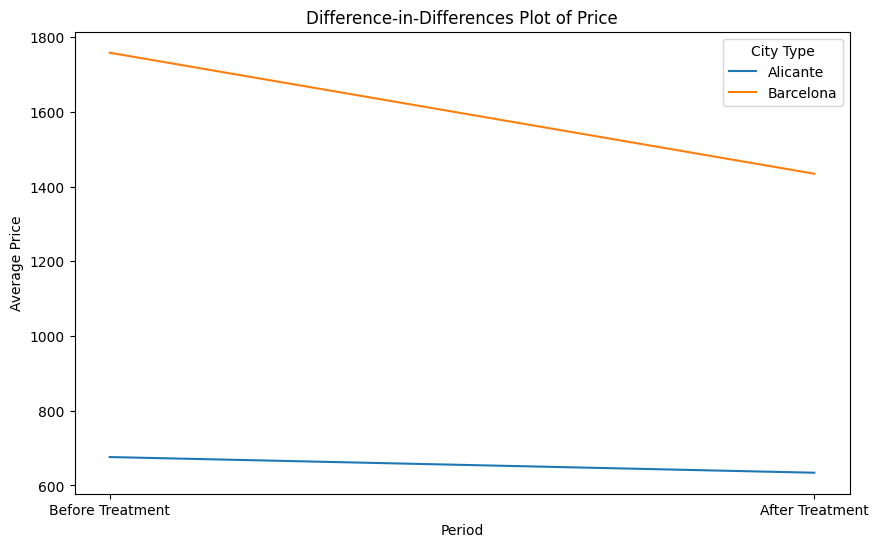

In [140]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has been processed as before

# Calculate the averages again if needed
grouped = data.groupby(['Treatment_City', 'Treatment_Period'])['Price'].mean().unstack()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
# Assuming Treatment_City has identifiable names for cities, use them directly in the plot
# For demonstration, let's manually specify the city names for legend if they are coded as 0 and 1
city_names = {0: 'Alicante', 1: 'Barcelona'}  # Update these based on your data

# Plot each group with a loop to manually control colors, markers, etc.
for city_code, group_data in grouped.iterrows():
    group_data.plot(ax=ax, label=city_names.get(city_code, f'City {city_code}'))

ax.set_title('Difference-in-Differences Plot of Price')
ax.set_ylabel('Average Price')
ax.set_xlabel('Period')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Before Treatment', 'After Treatment'], rotation=0)

# Add legend
ax.legend(title="City Type")

plt.show()


Treatment period is indeed significant for Barcelona hotel prices. Interestingly, the prices actually went down during the treatment week, which may indicate there is another event the weekend before which is even bigger, or that our event is not big enough to substantially affect hotel prices.

In [121]:
data_barcelona = data[data['Treatment_City'] == 1]
data_alicante = data[data['Treatment_City'] == 0]

#Running the regression again for Barcelona:

X_barcelona = data_barcelona[['Treatment_Period', 'Rating', 'amenities', 'location']]
X_barcelona = sm.add_constant(X_barcelona)

y_barcelona = data_barcelona['Price']

model = sm.OLS(y_barcelona, X_barcelona).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     11.15
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           5.96e-09
Time:                        12:31:56   Log-Likelihood:                -17538.
No. Observations:                2052   AIC:                         3.509e+04
Df Residuals:                    2047   BIC:                         3.511e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1816.2355    231.936  

The treatment effect is also significant for Alicante, albeit with a far smaller effect size. It is odd that the treatment period was not significant when averaged across the two cities, but this can happen, especially when the sample sizes are dissimilar. There may be a factor influencing hotel prices across Spain (or a region of it), and then another factor influencing just Barcelona hotel prices. There are likely many factors that influence hotel prices, especially in a large city like Barcelona, so this result is reasonable.

In [122]:
#Running the regression again for Alicante:

X_alicante = data_alicante[['Treatment_Period', 'Rating', 'amenities', 'location']]
X_alicante = sm.add_constant(X_alicante)

y_alicante = data_alicante['Price']

model = sm.OLS(y_alicante, X_alicante).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     28.64
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           4.32e-23
Time:                        12:32:10   Log-Likelihood:                -13324.
No. Observations:                1765   AIC:                         2.666e+04
Df Residuals:                    1760   BIC:                         2.669e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              269.1565    101.327  

In [87]:
data['Price']

0        1.104
1        2.564
2      960.000
3        1.003
4      828.000
        ...   
871      1.440
872      2.742
873    193.000
874    280.000
875    445.000
Name: Price, Length: 3817, dtype: float64